You will specifically learn about:

* Block-level matrix multiplications.

* Multi-dimensional pointer arithmetic.

* Program re-ordering for improved L2 cache hit rate.

* Automatic performance tuning.

In [88]:
import torch
import triton
import triton.language as tl

DEVICE = triton.runtime.driver.active.get_active_torch_device()


def get_cuda_autotune_config() -> list[triton.Config]:
    return [
        triton.Config({"BLOCK_SIZE_M": 128, "BLOCK_SIZE_N": 256, "BLOCK_SIZE_K": 64, "GROUP_SIZE_M": 8}, num_stages=3, num_warps=8),
        triton.Config({"BLOCK_SIZE_M": 128, "BLOCK_SIZE_N": 128, "BLOCK_SIZE_K": 32, "GROUP_SIZE_M": 8}, num_stages=4, num_warps=4),
        triton.Config({"BLOCK_SIZE_M": 128, "BLOCK_SIZE_N": 64, "BLOCK_SIZE_K": 32, "GROUP_SIZE_M": 8}, num_stages=4, num_warps=4),
        triton.Config({"BLOCK_SIZE_M": 128, "BLOCK_SIZE_N": 32, "BLOCK_SIZE_K": 32, "GROUP_SIZE_M": 8}, num_stages=4, num_warps=4),
        triton.Config({"BLOCK_SIZE_M": 64, "BLOCK_SIZE_N": 256, "BLOCK_SIZE_K": 32, "GROUP_SIZE_M": 8}, num_stages=4, num_warps=4),
        triton.Config({"BLOCK_SIZE_M": 64, "BLOCK_SIZE_N": 128, "BLOCK_SIZE_K": 32, "GROUP_SIZE_M": 8}, num_stages=4, num_warps=4),
        triton.Config({"BLOCK_SIZE_M": 64, "BLOCK_SIZE_N": 32, "BLOCK_SIZE_K": 32, "GROUP_SIZE_M": 8}, num_stages=5, num_warps=2),
        triton.Config({"BLOCK_SIZE_M": 32, "BLOCK_SIZE_N": 64, "BLOCK_SIZE_K": 32, "GROUP_SIZE_M": 8}, num_stages=5, num_warps=2),
        # Good config for fp8 inputs.
        triton.Config({"BLOCK_SIZE_M": 256, "BLOCK_SIZE_N": 128, "BLOCK_SIZE_K": 128, "GROUP_SIZE_M": 8}, num_stages=3, num_warps=8),
        triton.Config({"BLOCK_SIZE_M": 256, "BLOCK_SIZE_N": 64, "BLOCK_SIZE_K": 128, "GROUP_SIZE_M": 8}, num_stages=4, num_warps=4),
        triton.Config({"BLOCK_SIZE_M": 128, "BLOCK_SIZE_N": 256, "BLOCK_SIZE_K": 128, "GROUP_SIZE_M": 8}, num_stages=3, num_warps=8),
        triton.Config({"BLOCK_SIZE_M": 128, "BLOCK_SIZE_N": 128, "BLOCK_SIZE_K": 128, "GROUP_SIZE_M": 8}, num_stages=4, num_warps=4),
        triton.Config({"BLOCK_SIZE_M": 128, "BLOCK_SIZE_N": 32, "BLOCK_SIZE_K": 64, "GROUP_SIZE_M": 8}, num_stages=4, num_warps=4),
        triton.Config({"BLOCK_SIZE_M": 128, "BLOCK_SIZE_N": 64, "BLOCK_SIZE_K": 64, "GROUP_SIZE_M": 8}, num_stages=4, num_warps=4),
        triton.Config({"BLOCK_SIZE_M": 64, "BLOCK_SIZE_N": 256, "BLOCK_SIZE_K": 128, "GROUP_SIZE_M": 8}, num_stages=4, num_warps=4),
        triton.Config({"BLOCK_SIZE_M": 64, "BLOCK_SIZE_N": 128, "BLOCK_SIZE_K": 64, "GROUP_SIZE_M": 8}, num_stages=4, num_warps=4),
    ]


@triton.jit
def leaky_relu_kernel(x):
    return tl.where(x >= 0, x, x * 0.01)


@triton.autotune(configs=get_cuda_autotune_config(), key=["M", "N", "K"])
@triton.jit
def triton_mm_nn_kernel(
    a_ptr,
    b_ptr,
    c_ptr,
    M,
    N,
    K,
    am_stride,
    ak_stride,
    bk_stride,
    bn_stride,
    cm_stride,
    cn_stride,
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
    BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr,
    ACTIVATION: tl.constexpr,
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """

    # ----------------------------------------------------------
    # In one group, pid will allocate to m,n in column-major order.
    # In this way, we can promote L2 cache reuse.
    pid = tl.program_id(axis=0)
    num_pid_m, num_pid_n = tl.cdiv(M, BLOCK_SIZE_M), tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_group = GROUP_SIZE_M * num_pid_n
    # split contiguous program id into groups
    group_idx = pid // num_pid_group
    first_pid_m = group_idx * GROUP_SIZE_M
    group_size_m = min(GROUP_SIZE_M, num_pid_m - first_pid_m)
    # re-map pid_in_group in column-major order
    pid_in_group = pid % num_pid_group
    pid_m = first_pid_m + (pid_in_group % group_size_m)
    pid_n = pid_in_group // group_size_m

    # -----------------------------------------------------------
    # Add some integer bound assumptions.
    # This helps to guide integer analysis in the backend to optimize
    # load/store offset address calculation
    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(am_stride > 0)
    tl.assume(ak_stride > 0)
    tl.assume(bn_stride > 0)
    tl.assume(bk_stride > 0)
    tl.assume(cm_stride > 0)
    tl.assume(cn_stride > 0)

    # -----------------------------------------------------------
    # Compute begin offset to A,B for partial tiles
    offsets_m = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offsets_n = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offsets_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + offsets_m[:, None] * am_stride + offsets_k[None, :] * ak_stride
    b_ptrs = b_ptr + offsets_k[:, None] * bk_stride + offsets_n[None, :] * bn_stride

    # -----------------------------------------------------------
    # Main loop over K
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for block_k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        a = tl.load(a_ptrs, mask=offsets_k[None, :] < K - block_k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offsets_k[:, None] < K - block_k * BLOCK_SIZE_K, other=0.0)
        accumulator = tl.dot(a, b, accumulator)
        a_ptrs = a_ptrs + BLOCK_SIZE_K * ak_stride
        b_ptrs = b_ptrs + BLOCK_SIZE_K * bk_stride

    accumulator = accumulator.to(tl.float32)
    if ACTIVATION == "leaky_relu":
        accumulator = leaky_relu_kernel(accumulator)
    c = accumulator.to(tl.float16)

    # -----------------------------------------------------------
    # write back
    offsets_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offsets_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + offsets_cm[:, None] * cm_stride + offsets_cn[None, :] * cn_stride
    mask_cm = (offsets_cm[:, None] < M) & (offsets_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=mask_cm)


def triton_mm_nn(a: torch.Tensor, b: torch.Tensor, act=""):
    assert a.shape[1] == b.shape[0]
    assert a.is_contiguous()
    M, N, K = a.shape[0], b.shape[1], a.shape[1]
    c = torch.zeros((M, N), device=a.device, dtype=torch.float16)
    grid = lambda META: (triton.cdiv(M, META["BLOCK_SIZE_M"]) * triton.cdiv(N, META["BLOCK_SIZE_N"]),)
    triton_mm_nn_kernel[grid](a, b, c, M, N, K, a.stride(0), a.stride(1), b.stride(0), b.stride(1), c.stride(0), c.stride(1), ACTIVATION=act)
    return c

In [96]:
def sanity_check():
    M = 768
    N = 512
    K = 512
    A = torch.randn(M, K, device=DEVICE, dtype=torch.float16)
    B = torch.diag(torch.ones([K,], device=DEVICE, dtype=torch.float16))
    C = triton_mm_nn(A, B)
    C_ref = torch.matmul(A, B)
    print(f"float16 sanity check passed -> ", torch.allclose(C, C_ref))

    A = A.to(torch.float8_e4m3fn)
    B = B.to(torch.float8_e4m3fn)
    C = triton_mm_nn(A, B)
    C_ref = torch.matmul(A.to(torch.float16), B.to(torch.float16))
    print(f"FP8 sanity check passed -> ", torch.allclose(C, C_ref))


sanity_check()

float16 sanity check passed ->  True
FP8 sanity check passed ->  True


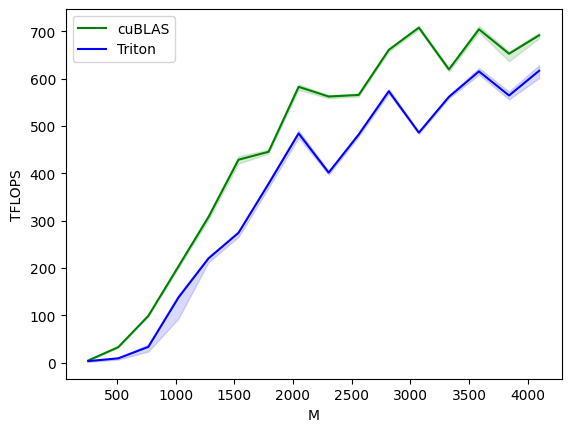

matmul-performance-fp16:
         M       N       K      cuBLAS      Triton
0    256.0   256.0   256.0    4.660338    3.415557
1    512.0   512.0   512.0   32.896503    9.279433
2    768.0   768.0   768.0   98.991442   33.465192
3   1024.0  1024.0  1024.0  203.360188  137.518167
4   1280.0  1280.0  1280.0  307.680742  220.289079
5   1536.0  1536.0  1536.0  428.962906  274.536263
6   1792.0  1792.0  1792.0  445.677298  377.994292
7   2048.0  2048.0  2048.0  582.921711  484.540510
8   2304.0  2304.0  2304.0  562.481171  401.687799
9   2560.0  2560.0  2560.0  565.880187  482.325662
10  2816.0  2816.0  2816.0  661.134368  573.635312
11  3072.0  3072.0  3072.0  708.065408  486.165640
12  3328.0  3328.0  3328.0  619.779805  561.883283
13  3584.0  3584.0  3584.0  704.528065  615.595298
14  3840.0  3840.0  3840.0  652.881475  564.650010
15  4096.0  4096.0  4096.0  691.843984  616.915734


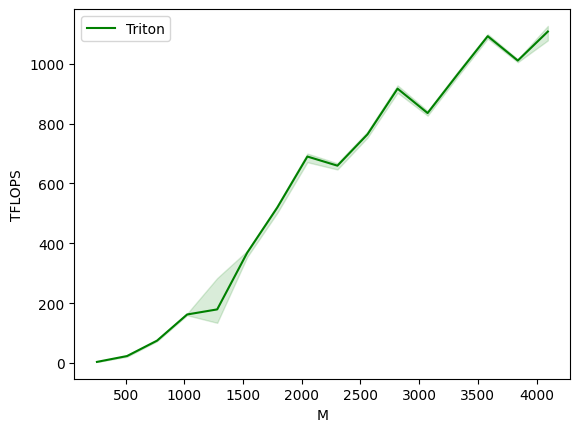

matmul-performance-fp8:
         M       N       K       Triton
0    256.0   256.0   256.0     3.554495
1    512.0   512.0   512.0    23.109113
2    768.0   768.0   768.0    74.700664
3   1024.0  1024.0  1024.0   162.098702
4   1280.0  1280.0  1280.0   179.060113
5   1536.0  1536.0  1536.0   368.880145
6   1792.0  1792.0  1792.0   519.742171
7   2048.0  2048.0  2048.0   690.065451
8   2304.0  2304.0  2304.0   659.544365
9   2560.0  2560.0  2560.0   764.268238
10  2816.0  2816.0  2816.0   916.987322
11  3072.0  3072.0  3072.0   835.380056
12  3328.0  3328.0  3328.0   965.111629
13  3584.0  3584.0  3584.0  1092.366176
14  3840.0  3840.0  3840.0  1010.838013
15  4096.0  4096.0  4096.0  1107.949788


In [95]:
configs = []
ref_lib = "cuBLAS"
for fp8_inputs in [False, True]:
    configs.append(
        triton.testing.Benchmark(
            x_names=["M", "N", "K"],  # Argument names to use as an x-axis for the plot
            x_vals=[128 * i for i in range(2, 33, 2)],  # Different possible values for `x_name`
            line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
            # Possible values for `line_arg`
            # Don't compare to cublas for fp8 cases as torch.matmul doesn't support fp8 at the moment.
            line_vals=["triton"] if fp8_inputs else [ref_lib.lower(), "triton"],  # Label name for the lines
            line_names=["Triton"] if fp8_inputs else [ref_lib, "Triton"],  # Line styles
            styles=[("green", "-"), ("blue", "-")],
            ylabel="TFLOPS",  # Label name for the y-axis
            plot_name="matmul-performance-" +
            ("fp16" if not fp8_inputs else "fp8"),  # Name for the plot, used also as a file name for saving the plot.
            args={"fp8_inputs": fp8_inputs},
        ))


@triton.testing.perf_report(configs)
def benchmark(M, N, K, provider, fp8_inputs):
    a = torch.randn((M, K), device=DEVICE, dtype=torch.float16)
    b = torch.randn((K, N), device=DEVICE, dtype=torch.float16)
    if fp8_inputs:
        a = a.to(torch.float8_e4m3fn)
        b = b.T
        b = b.to(torch.float8_e4m3fn)
    quantiles = [0.5, 0.2, 0.8]
    if provider == ref_lib.lower():
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, b), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_mm_nn(a, b), quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark.run(show_plots=True, print_data=True)